# Assignment 4 CNN, CAE, LSTM, GNN

In [1]:
from google.colab import drive
import os 

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/cpsc552hw4')

Mounted at /content/drive


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid 
import matplotlib.pyplot as plt

# Problem 1 CNN

In this problem, you will review some of the unique parameters involved in the construction of convolutional neural networks (CNNs). 

Then you will train a CNN on MNIST using the code provided in `p1.py` and visualize a sample of the learned filters of the network.

## dim of feature maps

Tracking the dimensionality of representations as they pass through the CNN is slightly different than for fully-connected networks. 

For the following, give the final output dimensions in terms of height h and width w if the size of the input image is 50x50 (h x w).  

Here k,  s,  and p  refer to kernel size, stride and padding, respectively. 

For a) and b), assume the image is passing through a convolutional layer 

while for c) and d), assume a max-pooling layer. Assume a square kernel. 

(a)  k=4, s=1, p=1: 49 x 49

(b)  k=8, s=5, p=0: 9 x 9
 
(c) k=10, s=2, p=2: 23 x 23

(d)  k=2, s=1, p=0: 49 x 49


### conv layer

Suppose the output shape is $n_H \times n_W$, we have

$$
n_H = \left \lfloor \frac{n_h - k_h + 2p_h }{s_h}\right \rfloor + 1,\ n_W = \left \lfloor \frac{n_w - k_w + 2p_w}{s_w}\right \rfloor + 1
$$

where $n_h$ and $n_w$ is height and weight of input,

$k_h$ and $k_w$ is height and weight of kernel,

$p_h$ and $p_w$ is padding for the height and weight

$s_h$ and $s_w$ is stride for the height and weight

In [1]:
def comp_conv2d(h, w, k, s, p):
    """ 
    calculate the shape of output of a 2D conv layer.
    adapted from https://d2l.ai/chapter_convolutional-neural-networks/padding-and-strides.html
    
    @params:
    h: input height
    w: input weight
    k: kernel size
    s: stride number for height and weight 
    p: padding number for height and weight
    
    return: a tuple of output shape
    H: height of output
    W: weight of output
    """
    # initialize a 2D conv kernel with 1 input channel and 1 output channel
    conv2d = nn.Conv2d(1, 1, kernel_size=(k, k), stride=(s, s), padding=(p, p))
    X = torch.rand(size=(1, 1, h, w)) # (batch_size, num_channels, height, weight) 
    Y = conv2d(X)
    return Y.shape[2:] # Exclude the first 2 dims (batch_size and channels)

In [ ]:
def comp_conv2d_2(h, w, k, s, p): 
    """
    calculate the shape of output of a 2D conv layer by formula 
    """
    return (h-k+2*p)//s + 1, (w-k+2*p)//s + 1

In [5]:
def compute_maxpool2d(h, w, k, s, p):
    """
    calculate the shape of output of a 2D maxpooling layer.
    """
    pool2d = nn.MaxPool2d((k, k), stride=(s, s), padding=(p, p))
    X = torch.rand(size=(1, 1, h, w))
    Y = pool2d(X)
    return Y.shape[2:]

In [7]:
params = [[50, 50, 4, 1, 1], [50, 50, 8, 5, 0]]
for param in params:
    print(comp_conv2d(*param))

params = [[50, 50, 10, 2, 2], [50, 50, 2, 1, 0]]
for param in params:
    print(compute_maxpool2d(*param))


torch.Size([49, 49])
torch.Size([9, 9])
torch.Size([23, 23])
torch.Size([49, 49])


## CNN on MNIST

### visualize filters

Train the model for 5 epochs in `CNN.py`

Visualize filters from the first convolutional layer (40 filters total). 

Text(0.5, 0.98, 'Filters of first conv layer of CNN on MNIST')

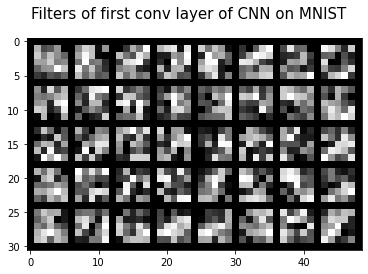

In [ ]:
from cnn import CNN 
model = CNN()
checkpoint = torch.load("./results/mnist_cnn.pt") 
model.load_state_dict(checkpoint)  

filters_conv1 = model.conv1.weight.data # [40, 1, 5, 5]
filters_conv1 = make_grid(filters_conv1, normalize=True, scale_each=True, nrow=8, padding=1) # [3, 31, 49]

plt.imshow(filters_conv1.numpy().transpose((1, 2, 0)))
plt.suptitle("Filters of first conv layer of CNN on MNIST", fontsize=15)
# save_image(filters_conv1, "./filters_conv1.png")

Text(0.5, 0.98, 'Filters of first conv layer of CNN on MNIST')

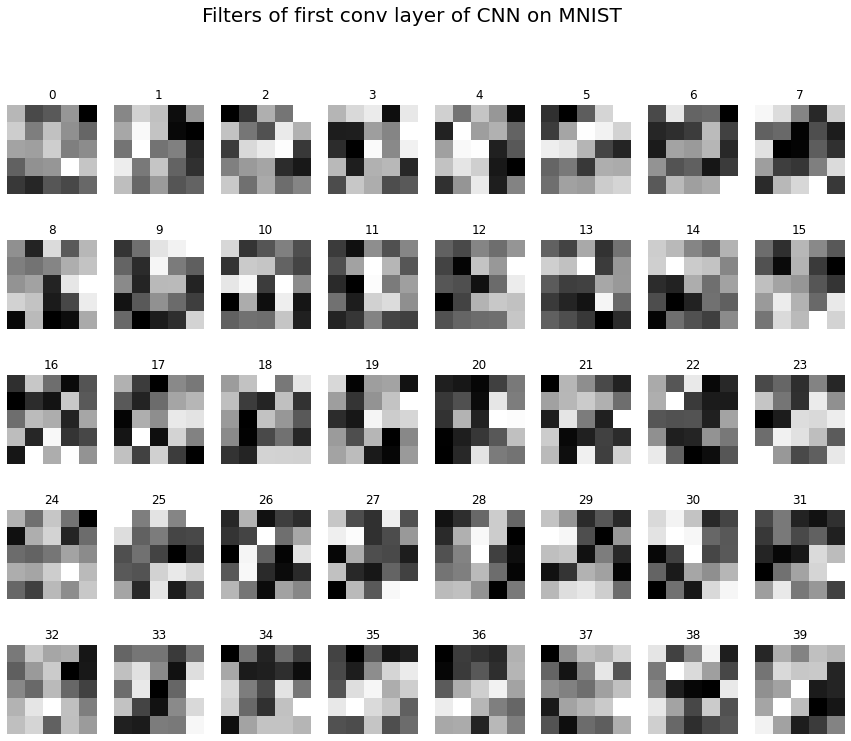

In [ ]:
filters_conv1 = model.conv1.weight.data # torch.Size([40, 1, 5, 5])
 
fig, axs = plt.subplots(5, 8, figsize=(15, 12)) # 5*8=40
for i in range(5):
    for j in range(8):
        f = filters_conv1[8*i+j, 0, :, :]
        axs[i, j].imshow(f[:, :], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title(8*i+j)
plt.suptitle("Filters of first conv layer of CNN on MNIST", fontsize=20)

### confusion matrix

Produce a confusion matrix using the test split and comment on any noticeable class confusion (one class is commonly mislabeled as the other). 

- Among the 10,000 samples in test split, Digit 5 is misclassified as digit 3 by 11 times and digit 7 is misclassified as digit 2 by 11 times, which are the most frequent misclassifications; digit 9 is misclassified as digit 8 by 10 times and as digit 3 by 9 times. It makes sense because these digits are similar in some features.

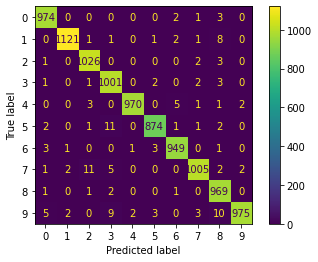

In [ ]:
def plt_conf_matrix(model, test_data, test_labels, filename)

# Problem 2 Autoencoder variants

## PCA

Principal Component Analysis (PCA) is a very common method for dimensionality reduction. 

(1) Conceptually, describe how the principal components in PCA are chosen. 

  - PCA finds directions in data that explain the most variance. An algorithm to find Principle components of PCA is to first compute the covariance matrix $\Sigma$ of data $X$, then do eigendecomposition of that covariance matrix: 
  
  $$\Sigma = U \Lambda U^{-1}$$
  
  where column vectors in the $U$ are eigenvectors of covariance matrix, diagonal entries in the diagonal matrix $\Lambda$ are corresponding eigenvalues $\lambda$, then the loadings can be found in the orthonormal matrix $U$. Principal components of data are $UX$. Any principal component is a linear combination of original features.


(2) If PCA is to implemented in PyTorch, the function `torch.svd()` will play an important role in the algorithm. 

Please briefly describe what this function does, and why the results will be useful in implementing PCA.

- `torch.svd()` do singular value decomposition (SVD) of a real matrix. It's a generalization of eigendecomposition of a non-square matrix. Any real matrix has a SVD. a preferred method to compute PCA is via SVD rather than eigendecomposition, because SVD has more numerical stability for computing tiny singular values than EIG. Since our data is often a non-square matrix, we can directly apply SVD to our data without computing its covariance matrix.

  for data matrix $X$, by convention, we first flip the matrix to be $X^T$, then do SVD of $X^T$:

  $$
  X^T = USV^T
  $$

  The loadings are columns of matrix $V$ and the principal components are $US$.

## PCA VS. AE

Describe the similarity between PCA and an autoencoder.

- Autoencoder can be used as a dimensionality reduction method as PCA when the dimensionality of code (bottleneck) is smaller than input. And can be used for denoising


- The latent space of Autoencoder will be similar to the embedding space of PCA if the activation function of encoder is linear.



## denoise AE vs. VAE

What similarities and differences are there between a denoising autoencoder and a variational autoencoder?

- Differences: loss function

  Denoising AE: minimize reconstruction loss of input and reconstructed noisy input

  VAE: reconstruction loss of input and reconstructed input and KL divergence which penalize the distribution in the latent space from being too far from the standard normal distribution.

- Similarity: both involve noise. 

  Denoising AE: add noise to corrupt the original input to get a noisy version of input to train the model together with the original input.

  VAE: add noise sampling from standard normal distribution as input in the reparameterization trick to make the backpropagation of mean and standard deviation work.


## conv AE vs. linear AE

What is the difference between a convolutional autoencoder and linear autoencoder? 


- Conv AE has convolutional layers while linear AE has linear layers. 

- Conv AE is better at image tasks than linear AE because convolution operations are good at capturing local spatial structures in the image. 

- The inputs for these 2 kinds of AEs are different, the input of conv AE can be a 2D (height x width) tensor of original image shape while the input of linear AE must be a flattened 1D tensor.

## CAE

Implement a convolutional autoencoder and save it as `CAE.py`. 

Compare the results of your autoencoder with the original images. 

Include in your report both the original images and the reconstructed images (there should be 8 images in total). 

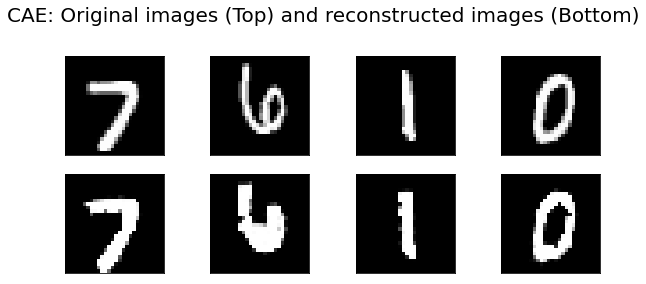

In [49]:
from CAE import CAE 
model = CAE() 
checkpoint = torch.load("./results/mnist_CAE.pt") 
model.load_state_dict(checkpoint)

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
output = model(images).view(-1, 1, 28, 28).detach().numpy()
images = images.numpy()

# plot the first 4 input images and 4 reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(10,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.suptitle("CAE: Original images (Top) and reconstructed images (Bottom)", fontsize=20, y=1.05)
plt.savefig(f'./results/cae_original_reconstructed.png', bbox_inches='tight')


# Problem 3 LSTM Autoencoder

goal: learn word embeddings of a text corpus of your choosing – not via the famous Word2Vec, but through an alternate strategy consisting of two parts. 

1. vectorize your words via an **embedding lookup matrix**. 

2. feed sequences of these vectorized words (i.e., sentences) into an **sequence-to-sequence LSTM Autoencoder**. 

    An autoencoder consists of two parts: the encoder, which compresses the input data into a lower-dimensional representation, and the decoder, which reconstructs the input data from this lower-dimensional representation. 
    
    In an LSTM autoencoder, both the encoder and decoder use LSTM layers to handle sequential data.

    as LSTM model learns to compress and reproduce a sentence of 50 words, it will reshape the word embeddings to imbue their spatial position with semantic meaning.

Say that we have the input sentence *It is Shady Al who does not smile.* 

Here’s how our model work

$$
\text{sentence} \xrightarrow{\text{embedding\ matrix}} \text{word\ embeddings}\xrightarrow{\text{LSTM\ encoder}} \text{a\ sentence\ embedding}\xrightarrow[+\text{[BOS]}]{\text{LSTM\ decoder}}\text{first\ output}\xrightarrow{\text{classifer}}\text{first\ word}
$$

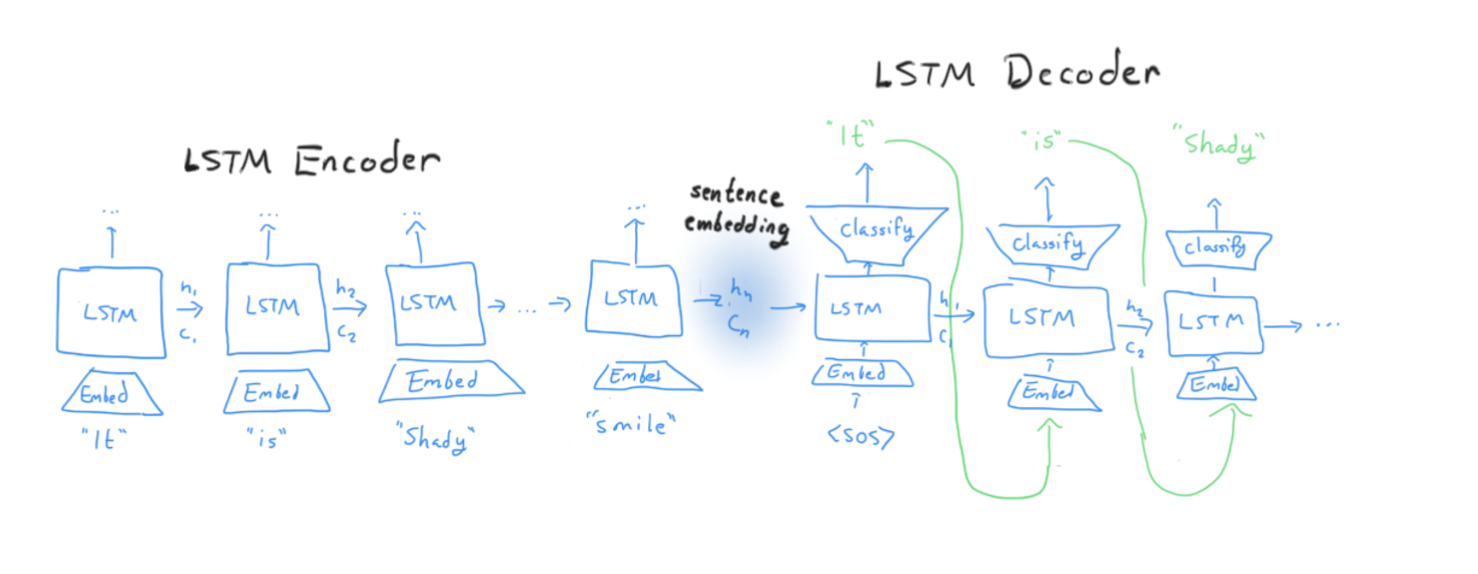

This model includes 4 parts, which should be unified under a single class `Seq2Seq`:

- A word embedding layer that converts a sequence of word indices into a vector in the embedding space of size (`seq_length`, `embed_size`). You can use `nn.Embedding` for this, which is a one-hot encoder followed by a linear layer, i.e. an embedding lookup matrix of size (`vocab_size, embed_size`)

- An LSTM encoder, which iteratively takes a sequence of word embeddings of size (`seq_length`, `embed_size`)and outputs a sentence embedding (the tuple `(h_n, c_n)`) of size (`num_layer`, `hidden_size`). In PyTorch, iterating through a sequence is done automatically; just pass the whole embedding vector, `nn.LSTM` will construct a chain resembling this.

- An separate LSTM decoder, which reconstructs the sentence from above sentence embedding. use `nn.LSTM`. To achieve this, we must apply the LSTM **iteratively** to its own output for the desired **sequence length**. Initially, it will take a beginning of sequence token [BOS] (a vector of zeroes) coupled with the sentence embedding, and will output a predicted word and a new hidden state. Next, it will take the **predicted word at last step** of size `vocab_size` and outputed hidden states (the tuple `(h_t, c_t)`) of size (`num_layer`, `hidden_size`), and will produce a new word prediction and hidden state. If using **teacher-forcing**, it will take the **ground truth word of last step** and outputed hidden state. We can then collect the predicted words and compare them with the ground truth sentence to compute a loss for the batch. Backpropogate, descend, and repeat!

- A classifier which translates a vector of size `hidden_size` from LSTM decoder output space into a vector of size `vocab_size` in the vocabulary space. A single `nn.Linear` layer will suffice here.

hyperparameters of LSTM

- sequence length: begin at 5, By tuning hyperparameters and increasing model capacity, try to **raise the sequence length as high** as you can while maintaining good reconstruction accuracy.

- embedding size

- **hidden size**: hidden sizes of encoder and decoder do not necessarily have to be the same. However, using the same hidden size can help maintain symmetry in architecture and simplifies the implementation and reduces the number of hyperparameters to tune during the training process.

- number of layers

- bidirectional

- teacher forcing ratio: using teacher forcing in ratio% iteration steps

## Implement an LSTM autoencoder

Implement an LSTM autoencoder in `Seq2SeqLSTM.py` to learn your own word embeddings.

To assess progress, you can translate your model’s reconstructions of the input sequences back into actual words. 

Watch out for the local minimum that reconstructs every sentence to ”the the the the the”! 

### create vocabulary

In [ ]:
! wget --no-check-certificate --content-disposition "https://raw.githubusercontent.com/amephraim/nlp/master/texts/J.%20K.%20Rowling%20-%20Harry%20Potter%201%20-%20Sorcerer's%20Stone.txt" --output-document="./data/J. K. Rowling - Harry Potter 1 - Sorcerer's Stone.txt"

--2022-04-15 02:01:24--  https://raw.githubusercontent.com/amephraim/nlp/master/texts/J.%20K.%20Rowling%20-%20Harry%20Potter%201%20-%20Sorcerer's%20Stone.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 439742 (429K) [text/plain]
Saving to: ‘./data/J. K. Rowling - Harry Potter 1 - Sorcerer's Stone.txt’

./data/J. K. Rowlin 100%[===================>] 429.44K  --.-KB/s    in 0.04s   

2022-04-15 02:01:24 (11.8 MB/s) - ‘./data/J. K. Rowling - Harry Potter 1 - Sorcerer's Stone.txt’ saved [439742/439742]



In [5]:
# TODO 1: put a text file of your choosing in the same directory and put its name here
TEXT_FILE = "./data/J. K. Rowling - Harry Potter 1 - Sorcerer's Stone.txt"

string = open(TEXT_FILE).read()

# convert text into tokens
tokens = re.split('\W+', string)

# get vocabulary
vocabulary = sorted(set(tokens))

# get corresponding index for each word in vocab
word_to_ix = {word: i for i, word in enumerate(vocabulary)}

VOCABULARY_SIZE = len(vocabulary)
print('vocab size: {}'.format(VOCABULARY_SIZE)) # 6654

vocab size: 6654


### define model



TODO 3: Define an LSTM model for an encoder that takes the input embeddings you created in the previous step and produces a final state.


`nn.LSTM`: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [9]:
# Test: get embeddings of first batch
i = 0
batch = [[vocabulary.index(v) for v in tokens[ii:ii + SEQ_LENGTH]] for ii in range(i, i + BATCH_SIZE)]
batch = np.stack(batch, axis=0)
batch = torch.tensor(batch, dtype=torch.long)
batch.shape # torch.Size([10, 50]) [batch_size, seq_length]
batch = batch.to(device) 

In [17]:

encoder = LSTM_Encoder(VOCABULARY_SIZE, EMBEDDING_SIZE, LSTM_SIZE).to(device)
batch = batch.to(device) 
hidden, cell = encoder(batch) # get context vector of a batch
hidden.shape, cell.shape


(torch.Size([1, 10, 64]), torch.Size([1, 10, 64]))

TODO 4: Define an LSTM model for a decoder that takes the final state of your encoder and produces a sequence of outputs that will be trained to reproduce the original sequence. 

You should be able to reuse much or all of the code from the previous part.

In [20]:
decoder = LSTM_Decoder(VOCABULARY_SIZE, EMBEDDING_SIZE, LSTM_SIZE).to(device)

# input is a batch of seq of length 1 (1 token)
pred, hidden, cell = decoder(batch[:,0].view(BATCH_SIZE, 1), hidden, cell)

print(pred.shape, pred.dtype)
print(hidden.shape, hidden.dtype)
print(cell.shape, cell.dtype)


torch.Size([10, 1, 6654]) torch.float32
torch.Size([1, 10, 64]) torch.float32
torch.Size([1, 10, 64]) torch.float32


In [37]:
encoder = LSTM_Encoder(VOCABULARY_SIZE, EMBEDDING_SIZE, LSTM_SIZE).to(device)
decoder = LSTM_Decoder(VOCABULARY_SIZE, EMBEDDING_SIZE, LSTM_SIZE).to(device)
model = Seq2Seq(encoder, decoder).to(device)
model

Seq2Seq(
  (encoder): LSTM_Encoder(
    (embedding): Embedding(6654, 100)
    (rnn): LSTM(100, 64, batch_first=True)
  )
  (decoder): LSTM_Decoder(
    (embedding): Embedding(6654, 100)
    (rnn): LSTM(100, 64, batch_first=True)
    (linear): Linear(in_features=64, out_features=6654, bias=True)
  )
)

In [ ]:
# Test: get embeddings of first batch
i = 0
batch = [[vocabulary.index(v) for v in tokens[ii:ii + SEQ_LENGTH]] for ii in range(i, i + BATCH_SIZE)]
batch = np.stack(batch, axis=0)
batch = torch.tensor(batch, dtype=torch.long)
batch.shape # torch.Size([10, 50]) [batch_size, seq_length]
batch = batch.to(device) 

out = model(batch)

## visualize word embeddings

### whole word embeddings

TODO 5: Plot the word embeddings with the given code. 

You are able to adjust the plotting parameters to suit your needs for making a compelling visualization. 

Discuss what you notice in your embeddings.

For example, using the introduction to Charles Darwin’s On the Origin of Species as a text file, I obtain this embeddings in Figure 1



In [47]:
# plot word embeddings
# assuming embeddings called "learned_embeddings"
encoder = LSTM_Encoder(VOCABULARY_SIZE, EMBEDDING_SIZE, LSTM_SIZE).to(device)
decoder = LSTM_Decoder(VOCABULARY_SIZE, EMBEDDING_SIZE, LSTM_SIZE).to(device)
model = Seq2Seq(encoder, decoder).to(device)
model.load_state_dict(torch.load('./results/LSTM.pt'))
model.eval()

vocab = torch.tensor(range(VOCABULARY_SIZE)).to(device)
learned_embeddings = model.encoder.embedding(vocab).detach().cpu().numpy()
# shape: (6654, 2)
learned_embeddings_pca = sklearn.decomposition.PCA(2).fit_transform(learned_embeddings)

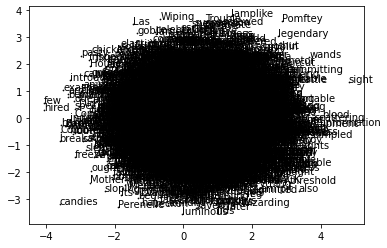

In [48]:
# plot all the word embeddings
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(learned_embeddings_pca[:, 0], learned_embeddings_pca[:, 1], s=0.5, c='black')
for i in range(VOCABULARY_SIZE):
    ax.annotate(vocabulary[i], xy=learned_embeddings_pca[i])

### subsampled word embeddings

Since this is too crowded to interpret, we’ve provided code to randomly select words to plot as long as there is space as shown in Figure 2. 

Either use this code multiple times or create your own code to obtain a visualization(s) that facilitates allows you to learn something about your data. 

Include this visualization in your report

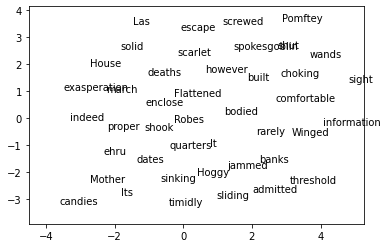

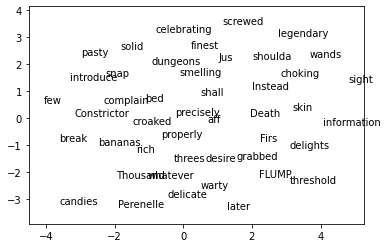

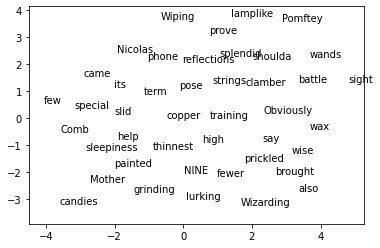

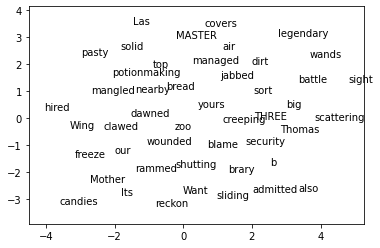

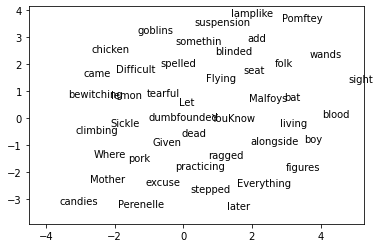

In [49]:
# plot sampled word embeddings, run 5 times
for i in range(5):
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  ax.scatter(learned_embeddings_pca[:, 0], learned_embeddings_pca[:, 1], s=5, c='w')
  MIN_SEPARATION = .1 * min(ax.get_xlim()[1] - ax.get_xlim()[0], ax.get_ylim()[1] - ax.get_ylim()[0])

  xy_plotted = set()

  for i in np.random.choice(VOCABULARY_SIZE, VOCABULARY_SIZE, replace=False):
      x_, y_ = learned_embeddings_pca[i]
      if any([(x_ - point[0])**2 + (y_ - point[1])**2 < MIN_SEPARATION for point in xy_plotted]): continue
      xy_plotted.add(tuple([learned_embeddings_pca[i, 0], learned_embeddings_pca[i, 1]]))
      ax.annotate(vocabulary[i], xy=learned_embeddings_pca[i])
     

The text I used is a book ***Harry Porter I Sorcerer's Stone***. The words with similar meaning or used in the same context in the plots of word embeddings are expected to be close, but I don't find such patterns in the multiple plots I generated, they are more like random words occurred together.

# Problem 4 GCN

## define a convolutional operator on graph domain

Graph convolutional networks are modeled explicitly after classical CNNs. 

The graph domain, however, poses unique challenges: whereas every pixel in an image is connected to its neighbors in the same way, nodes in a graph exhibit a range of local structures that make it impossible to define a convolutional operator as a dot product with a filter. 

Reading:

- first GCN, [Kipf 2017: Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/pdf/1609.02907.pdf) 

- blog reviews Kipf and Welling’s approach: [How Powerful are Graph Convolutional Networks?](https://www.inference.vc/how-powerful-are-graph-convolutions-review-of-kipf-welling-2016-2/)

- How does the GCN of Kipf and Welling draw upon spectral graph theory to overcome these difficulties? 

  The spectral graph theory transforms the signal on a spatial domain to the frequency domain by graph Fourier transform of eigenvectors in the graph Laplacian matrix. The convolution is defined as the product of transformed signal and transformed filter which can be approximated by the first 2 order Chebyshev polynomials. 


- Are there any problems with this approach? 

  The convolution kernel is isotropic because only the first 2 order polynomials are used. Therefore, this operator can't detect directional changes like CNN. 


- what alternate ways exist of defining convolutions in the graph domain?

  Graph convolution can be also defined in the spatial domain (i.e., vertex domain) as the aggregations of representations from node neighborhoods.






## Geometric

Geometric is a powerful library that makes building GNNs as easy as building CNNs with PyTorch. 

tutorial: https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html

Geometric also contains a large number of benchmark graph datasets, 

e.g., all Planetoid datasets (Cora, Citeseer, Pubmed), all graph classification datasets from http://graphkernels.cs.tu-dortmund.de and their cleaned versions, the QM7 and QM9 dataset, and a handful of 3D mesh/point cloud datasets like FAUST, ModelNet10/40 and ShapeNet. 



Follow the installation instructions to set it up on your machine. 

https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html

https://gist.github.com/ameya98/b193856171d11d37ada46458f60e73e7

## Message-passing layer

https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html

Generalizing the convolution operator to irregular domains is typically expressed as a neighborhood aggregation or message passing scheme. 

message passing graph neural networks can be described as

$$
\mathbf{x}_i^{(k)} = \gamma^{(k)} \left( \mathbf{x}_i^{(k-1)}, \text{AGG}_{j \in \mathcal{N}(i)} \, \phi^{(k)}\left(\mathbf{x}_i^{(k-1)}, \mathbf{x}_j^{(k-1)},\mathbf{e}_{j,i}\right) \right)
$$

where 

$\mathbf{x}^{(k-1)}_i \in \mathbb{R}^F$ denoting node features of node i in layer (k-1) 

$\mathbf{e}_{j,i} \in \mathbb{R}^D$ denoting (optional) edge features from node j to node i,

$\text{AGG}$ denotes a differentiable, permutation invariant function, e.g., sum, mean or max, 

$\gamma$ and $\phi$ denote differentiable functions such as MLPs (Multi Layer Perceptrons).

### baseline: GCNConv

the `GCNConv` class below implement a simple message passing layer same as [`GCNConv` class from `torch_geometric.nn`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html#torch_geometric.nn.conv.GCNConv) with following operations:

- normalization in aggregation

- $\gamma$ is a simple identity function

the GCN layer computes the output feature matrix $X' \in \mathbb{R}^{N \times F'}$, where $F'$ is the number of output features, as follows:

$$
X'=D^{-1/2}AD^{-1/2}XW
$$

Where:

$X$ is the input node feature matrix with shape [num_nodes, in_channels].

$A$ is the adjacency matrix of the graph, possibly with added self-loops.

$D$ is the degree matrix of $A$, a diagonal matrix with the degree of each node on the diagonal.

$W$ is the learnable weight matrix with shape [in_channels, out_channels].

$X'$ is the output node feature matrix with shape [num_nodes, out_channels].

Algorithm

1. Add self-loops to the adjacency matrix $A$: $\hat{A} = A + I$, where $I$ is the identity matrix.

2. Compute the degree matrix $D$ of the graph with self-loops: $D_{ii} = \sum_{j} \hat{A}_{ij}$.

3. Calculate the inverse square root of the degree matrix: $D^{-\frac{1}{2}}$.
Normalize the adjacency matrix: $\tilde{A} = D^{-\frac{1}{2}} \hat{A} D^{-\frac{1}{2}}$.

4. Apply a linear transformation on the input features using a learnable weight matrix $W \in \mathbb{R}^{F \times F'}$: $XW$.

5. Perform the graph convolution: $X' = \tilde{A} (XW)$.




In [ ]:
import torch
from torch import nn 
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree


class GCNConv(MessagePassing):
    """
    build a simple message passing layer from Kipf & Welling. 
    """
    def __init__(self, in_channels, out_channels):
      # aggregation function can be mean, add, max, min
        super(GCNConv, self).__init__(aggr='add')  # "Add" aggregation (Step 4).

        self.linear = nn.Linear(in_channels, out_channels) # linear layer (Step 2)

    def forward(self, x, edge_index):
        """
        x: node embeddings, shape [N, in_channels]  
        edge_index: shape [2, E]
        N: number of nodes
        E: number of edges
        """

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        # neighboring node features are first transformed by a weight matrix W
        x = self.linear(x)

        # Step 3: Compute normalization.
        # row shape [num_edge], col shape [num_edge]
        row, col = edge_index

        # Computes the (unweighted) degree matrix 
        deg = degree(col, x.size(0), dtype=x.dtype)

        # compute square root of inverse of degree matrix
        deg_inv_sqrt = deg.pow(-0.5)

        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0

        # Compute normalization coefficients.
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        # x: node embeddings, norm: normalization coefficients
        # propagate function internally calls step 3 message(), step 4 aggregate() and step 5 update()
        return self.propagate(edge_index, size=(x.size(0), x.size(0)),
                              x=x, norm=norm)

    def message(self, x_j, norm):
        """
        normalize the neighboring node features x_j by norm

        @param:
        x_j: a lifted tensor has shape [E, out_channels], 
          contains the source node features of each edge. i.e., the neighbors of each node
        norm: normalization coefficients, shape [E, ]
        """

        # Step 3: Normalize node features.
        return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
      """
      Updates node embeddings using function γ for each node with aggregated message

      @param
      aggr_out: output of step 4 aggregate(), has shape [N, out_channels]
      """
      # Step 5: Return new node embeddings.
      return aggr_out

As multiple papers pointed out ([Xu et al. (2018)](https://arxiv.org/abs/1810.00826), [Morris et al. (2018)](https://arxiv.org/abs/1810.02244)), applying **neighborhood normalization decreases the expressivity of GNNs in distinguishing certain graph structures**.

### improved: GINConv

[`GINConv` class from `torch_geometric.nn`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GINConv.html#torch_geometric.nn.conv.GINConv)

Keyulu Xu's paper [ICLR 2019, How Powerful Are Graph Neural Networks?](https://openreview.net/pdf?id=ryGs6iA5Km) proposed a more powerful GCN, Graph Isomorphism Networks (GIN). 

- For $\gamma$, use a MLP

- Do not perform any normalization in the aggregation step $\phi$

- for neighbor aggregation, use learnable parameter $\epsilon \in \mathbb{R}$


update rule for features of node $i$ at layer $l+1$ is given by:

$$
H_i^{(l+1)} = \text{MLP}^{(l)}\left( \underset{\text{node feature}}{\underbrace{(1 + {\color{red}{\epsilon}}^{(l)}) * H_i^{(l)}}} + \underset{\text{neighbors feature}}{\underbrace{\sum_{j \in N(i)} A_{ij} * H_j^{(l)}}} \right)
$$

Here, $H_i^{(l+1)}$ represents the updated features of node $i$ at layer $(l+1)$, 

$A_{ij}$ is the adjacency matrix element between nodes $i$ and $j$, 

$H_j^{(l)}$ is the features of neigibor node $j$ at layer $l$, 

$N(i)$ denotes the neighbors of node $i$, 

$\text{MLP}^{(l)}$ is a multi-layer perceptron used at layer $l$

$\epsilon^{(l)}$ is a learnable parameter at layer $l$.

The term $(1 + \epsilon^{(l)}) H_i^{(l)}$ is a scaled version of the node's own features, with $\epsilon^{(l)}$ determining the **relative importance of the node's own features and the aggregated neighbor features.**

$$
\mathbf{X}^{\prime} = \text{MLP} \left( \left( \mathbf{A} +
        (1 + \epsilon) \cdot \mathbf{I} \right) \cdot \mathbf{X} \right)
$$

In [ ]:
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing

# Define the GINConv class, which inherits from the MessagePassing class
class GINConv(MessagePassing):
    def __init__(self, in_channels, out_channels, hidden_size):
        super(GINConv, self).__init__(aggr='add')  # Initialize the superclass with 'add' aggregation
        # Define the MLP used for feature transformation
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_channels)
        )  
        # Initialize the epsilon parameter
        self.eps = nn.Parameter(torch.Tensor([0]))  

    def forward(self, x, edge_index):
        # Propagate the messages through the graph
        out = self.propagate(edge_index, x=x)
        x_r = x[1]
        if x_r is not None:
            out = out + (1 + self.eps) * x_r 
        return self.mlp(out)

    def message(self, x_j):
        """No normalization"""
        return x_j 

    def update(self, aggr_out):
        # Update node features based on the aggregated messages
        return aggr_out


## node classification: CORA citation network

CORA is a standard benchmark dataset for semi-supervised graph node classification

The dataset contains only a single, undirected citation graph with 2708 nodes and 10556 edges

- node: an academic paper with 1433 features

- edge: citation link between papers with no feature

task: predict category (7) of each paper

run `NodeClassification.py`, compare accuracy of GCN using baseline GCNConv layer to improved GINConv layer

In [8]:
from torch_geometric.nn import GCNConv
class NodeClassifier_base(torch.nn.Module):
    def __init__(self, num_node_features, hidden_features, num_classes):
        super(NodeClassifier_base, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_features)
        self.conv2 = GCNConv(hidden_features, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

### load data

In [10]:
# - - - DATA PREPARATIONS - - -
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
dataset = Planetoid(root='./data/Planetoid/', name='Cora', transform=NormalizeFeatures())
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of node features: {dataset.num_node_features}')
print(f'Number of edge features: {dataset.num_edge_features}')
print(f'Number of classes: {dataset.num_classes}')

print("The dataset contains only a single, undirected citation graph:")
data = dataset[0]  # Get the first graph object.
print()

# shape of elements in data
print(data)
print('=============================================================')
# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'has isolated nodes: {data.has_isolated_nodes()}')
print(f'has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(f"Number of nodes to train: {data.train_mask.sum().item()}")
print(f"Number of nodes to validate: {data.val_mask.sum().item()}")
print(f"Number of nodes to test: {data.test_mask.sum().item()}")



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of node features: 1433
Number of edge features: 0
Number of classes: 7
The dataset contains only a single, undirected citation graph:

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
has isolated nodes: False
has self-loops: False
Is undirected: True
Number of nodes to train: 140
Number of nodes to validate: 500
Number of nodes to test: 1000


In [ ]:
data.keys 

['val_mask', 'edge_index', 'y', 'train_mask', 'test_mask', 'x']

In [ ]:
row, col = data.edge_index

In [ ]:
row.shape, col.shape 

(torch.Size([10556]), torch.Size([10556]))

`Data` object

https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data

- x (Tensor, optional) – Node feature matrix with shape [num_nodes, num_node_features]. (default: None)

- edge_index (LongTensor, optional) – Graph connectivity in Coordinate Format (COO) format with shape [2, num_edges]. (default: None)

  the tensor defining the source and target nodes of all edges. 2 accounts for the both directions of an edge.
  
  not a list of tuples

  see e.g. https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-handling-of-graphs


- edge_attr (Tensor, optional) – Edge feature matrix with shape [num_edges, num_edge_features]. (default: None)

- y (Tensor, optional) – Graph-level or node-level ground-truth labels with arbitrary shape. (default: None)

- pos (Tensor, optional) – Node position matrix with shape [num_nodes, num_dimensions]. (default: None)

- **kwargs (optional) – Additional attributes.

Mask

`test_mask=[2708], train_mask=[2708], val_mask=[2708]`

- `train_mask` denotes against which nodes to train (140 nodes),

- `val_mask` denotes which nodes to use for validation, e.g., to perform early stopping (500 nodes),

- `test_mask` denotes against which nodes to test (1000 nodes).

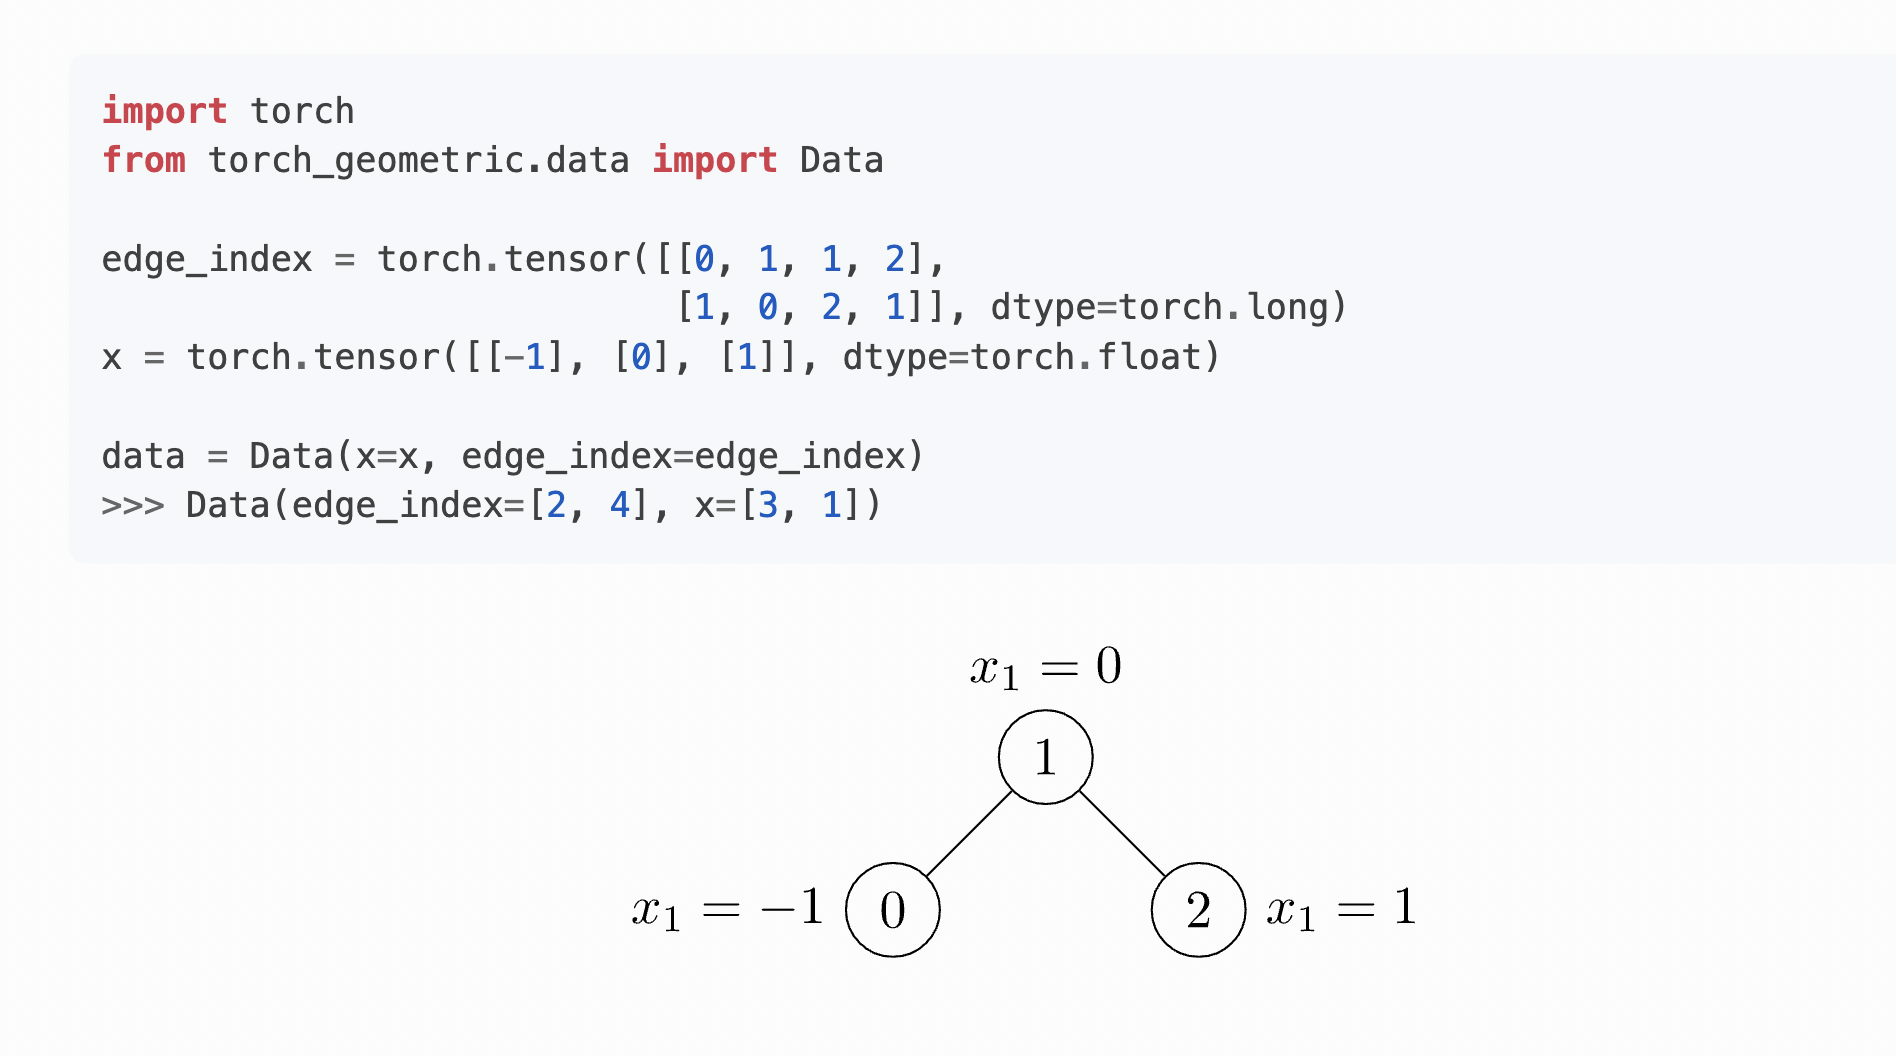

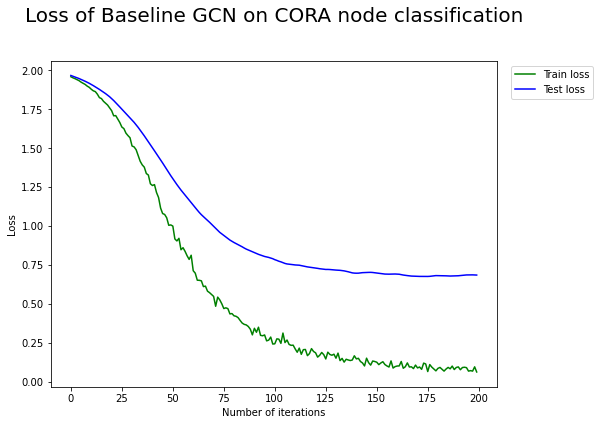

In [16]:
plot_loss(filename='./results/GCN_baseline_loss.npy', 
          title='Loss of Baseline GCN on CORA node classification')

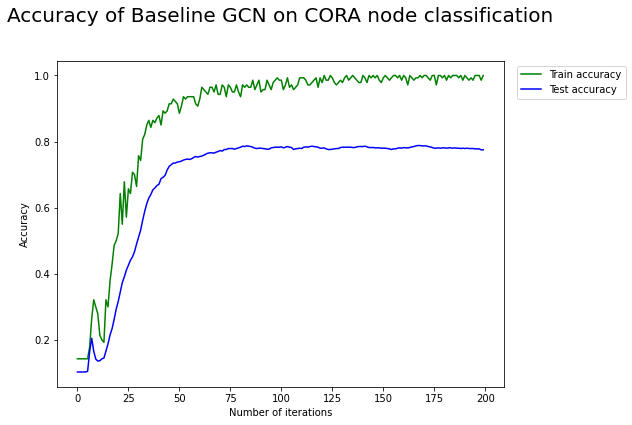

In [17]:
plot_acc(filename='./results/GCN_baseline_accuracy.npy', 
         title='Accuracy of Baseline GCN on CORA node classification')


## graph classification: REDDIT-BINARY dataset

REDDIT-BINARY dataset has 2000 graphs

Each graph depicts a single discussion thread on Reddit.

node: a user with a constant feature

edge: no feature. connecting those users who replied to each other’s comments.

task: predict which community (2) the thread comes from

run `GraphClassification.py`, compare accuracy of GCN using baseline GCNConv layer to improved GINConv layer 

In [5]:
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import Constant
# import the graph classifier you built in the last step
# from GCN import GraphClassifier, GCNGraphClassifier

In [ ]:
import torch
from torch import nn 
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool

class GraphClassifier(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features, num_classes):
        super(GraphClassifier, self).__init__()
        # Define graph convolutional layers
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        # Define linear classifier layer
        self.lin = nn.Linear(hidden_channels, num_classes)
        # Define batch normalization layer
        self.bn = nn.BatchNorm1d(hidden_channels, affine=False)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        
        # First graph convolutional layer
        x = self.conv1(x, edge_index)
        x = self.bn(x)
        x = x.relu()
        
        # Second graph convolutional layer
        x = self.conv2(x, edge_index)
        x = self.bn(x)
        x = x.relu()
        
        # Third graph convolutional layer
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        
        # Perform global mean pooling on node embeddings
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        
        # Apply dropout
        x = F.dropout(x, p=0, training=self.training)
        
        # Apply the linear classifier layer
        x = self.lin(x)
        
        return x


### load data

In [7]:
# - - - DATA PREPARATIONS - - -
from torch_geometric.datasets import TUDataset
dataset = TUDataset(
    root='./data/TUDataset/',
    name='REDDIT-BINARY',
    pre_transform=Constant() # the Reddit dataset has no node features of its own. 
    # This "Constant" pre-transform gives each node the value '1'.
    # If all goes according to plan, the GCN should be able to derive good graph representations from the connectivity of the graphs alone.
)
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of node features: {dataset.num_node_features}')
print(f'Number of edge features: {dataset.num_edge_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print()
print(data)
print('=============================================================')
# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')




Dataset: REDDIT-BINARY(2000):
Number of graphs: 2000
Number of features: 1
Number of node features: 1
Number of edge features: 0
Number of classes: 2

Data(edge_index=[2, 480], y=[1], x=[218, 1], num_nodes=218)
Number of nodes: 218
Number of edges: 480
Average node degree: 2.20
Has isolated nodes: False
Has self-loops: False
Is undirected: True


### training

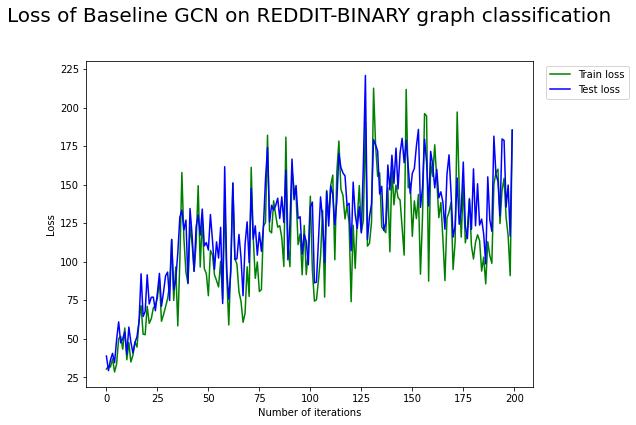

In [22]:
plot_loss(filename='./results/graph_cls_GCN_baseline_loss.npy', 
         title='Loss of Baseline GCN on REDDIT-BINARY graph classification')


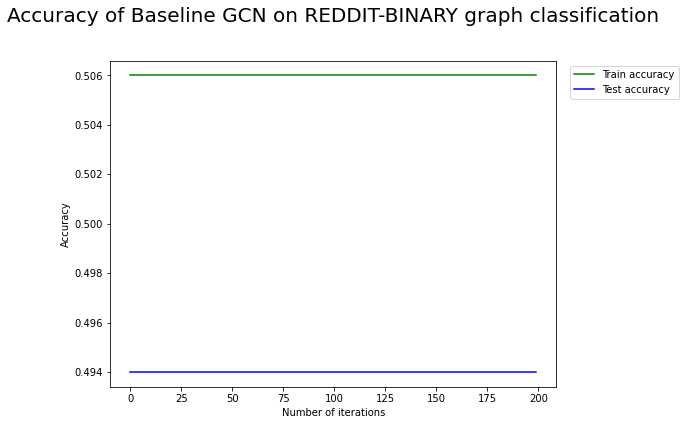

In [23]:
plot_acc(filename='./results/graph_cls_GCN_baseline_accuracy.npy', 
         title='Accuracy of Baseline GCN on REDDIT-BINARY graph classification')


# References

- CNN feature map shape: 

  https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks#layer

  https://d2l.ai/chapter_convolutional-neural-networks/padding-and-strides.html?fbclid=IwAR3ED3ndc6EFXU_06Ede7j0ji7HIN2-ADNRVp58FH2byUIPSVh9YX7Xhko4


- PCA SVD VS EIG: https://stats.stackexchange.com/questions/314046/why-does-andrew-ng-prefer-to-use-svd-and-not-eig-of-covariance-matrix-to-do-pca

- CAE: https://github.com/udacity/deep-learning-v2-pytorch/blob/master/autoencoder/convolutional-autoencoder/Convolutional_Autoencoder_Solution.ipynb

- LSTM Autoencoder: http://ethen8181.github.io/machine-learning/deep_learning/seq2seq/1_torch_seq2seq_intro.html#Data-Preparation

- GCN: 

  https://zqfang.github.io/2021-08-07-graph-pyg/

  https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html

  https://gist.github.com/ameya98/b193856171d11d37ada46458f60e73e7

  https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data

  https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-handling-of-graphs